In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [3]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [4]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [5]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
# df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [6]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').astype(float)

## 2. Add Features

In [7]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_day'] = pd.DatetimeIndex(df['start_date']).day
df['auc_season'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [8]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)

In [9]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [10]:
# returns nth_in_auction divided by lot_number = percentage through the auction the lot when lot was shown
lot_order_df = df[['nth_in_auction', 'number_of_lots']].copy()
df['percent_in_auction'] = np.round(lot_order_df.nth_in_auction / lot_order_df.number_of_lots, 3)*100

In [11]:
# Add avg_estimate
df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

## 3. Convert Currency

In [12]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = hammer_price.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_low_usd'] = est_low.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)    
df['estimate_high_usd'] = est_high.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_avg_usd'] = est_avg.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)

In [13]:
df['hammer_price_bp_usd'].describe()

count    1.881000e+04
mean     3.117394e+05
std      1.872662e+06
min      0.000000e+00
25%      8.894665e+03
50%      3.136310e+04
75%      1.116989e+05
max      7.941250e+07
Name: hammer_price_bp_usd, dtype: float64

In [14]:
# Add converted Hammer Price Range
def price_range(x):

    if x <10000:
        return "0-$10,000"
    elif x<50000:
        return "10,001-$50,000"
    elif x <500000:
        return "50,001-$500,000"
    else: return "$500,000+"
    
df["price_range"] = df["hammer_price_bp_usd"].apply(price_range)

In [15]:
df.sample(20)

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,end_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_day,auc_season,is_untitled,auc_order,percent_in_auction,estimate_avg,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd,price_range
7799,14838,193,IMPRINTS OF A NO. 50 PAINTBRUSH REPEATED AT RE...,30000.0,40000.0,43250.0,GBP,91,203,Colours: The colours in the catalogue illustra...,"Galleria Alfonso Artaco, Naples<br>Acquired di...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day Auction,163,LONDON,2011-10-14 11:00:00.363,2011-10-14 11:00:00.363,"OVERVIEW\n\n\nThe Contemporary Art Day sale, h...",L11025,4840,Niele Toroni,1937.0,NaN,2011-10-14,2011,10,14,4,0,5,55.8,35000.0,68261.63,47349.11,63132.14,55240.63,"50,001-$500,000"
12667,7916,79,STUBB,20000.0,30000.0,40000.0,USD,254,287,This work is in very good condition overall. T...,"Salon 94, New York<br>Acquired from the above ...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Curated featuring works from “In ...,343,NEW YORK,2017-03-02 15:00:00.695,2017-03-02 15:00:00.695,Results: The March Contemporary Curated sale f...,N09622,1193,Marilyn Minter,1948.0,NaN,2017-03-02,2017,3,2,2,0,7,74.1,25000.0,40000.00,20000.00,30000.00,25000.00,"10,001-$50,000"
20863,1738,14,UNTITLED,6000.0,8000.0,20000.0,GBP,7,107,Colour:\nThe colours in the catalogue illustra...,"Sprüth Magers Lee, London<br>Brooke Alexander,...",NaN,http://www.sothebys.com/content/dam/stb/lots/L...,1,Contemporary Art Day Auction,207,LONDON,2018-03-08 10:30:00.099,2018-03-08 10:30:00.099,Sotheby’s is delighted to present our upcoming...,L18021,23,Donald Judd,1928.0,1994,2018-03-08,2018,3,8,2,1,1,3.4,7000.0,28071.12,8421.34,11228.45,9824.89,"10,001-$50,000"
9634,10842,126,UNTITLED (19.4.84),80000.0,120000.0,161000.0,GBP,12,112,Colour:\nThe colours in the catalogue illustra...,"Galerie Fred Jahn, Munich<br>Acquired directly...","""Painting pictures is simply the official, the...",http://www.sothebys.com/content/dam/stb/lots/L...,1,Contemporary Art Day Auction,287,LONDON,2015-07-02 09:00:00.267,2015-07-02 09:00:00.267,RESULTS\n\nOur Contemporary Art Day Auction ac...,L15023,133,Gerhard Richter,1932.0,NaN,2015-07-02,2015,7,2,3,1,2,4.2,100000.0,250827.26,124634.66,186951.99,155793.33,"50,001-$500,000"
12959,12202,110,CLEOPATRA,30000.0,40000.0,133250.0,GBP,55,155,Colour:\nThe colours in the catalogue illustra...,"<p>Galerie Limmer, Freiburg<br>Sale: Sotheby's...",Please note that this work has been requested ...,http://www.sothebys.com/content/dam/default/un...,1,The Gunter Sachs Collection Day Auction,246,LONDON,2012-05-23 09:30:00.333,2012-05-23 09:30:00.333,"RESULTS\n\nLONDON, 23 May 2012 - Today’s Day S...",L12027,979,Mimmo Rotella,1918.0,2006,2012-05-23,2012,5,23,2,0,1,22.4,35000.0,209698.13,47211.59,62948.78,55080.18,"50,001-$500,000"
3323,22417,218,"VASE SOLIFLORE, 2006A GLASS BUD VASE BY SIMEON...",200.0,400.0,125.0,EUR,151,168,Très bon état général. \nPour tout renseigneme...,NaN,NaN,http://www.sothebys.com/content/dam/stb/lots/P...,1,"Photographs, Furniture, and Works of Art from ...",191,PARIS,2009-09-23 12:30:00.000,2009-09-23 12:30:00.000,NaN,F9093,8228,Simeon Caleb,NaN,NaN,2009-09-23,2009,9,23,4,0,8,79.1,300.0,184.79,295.66,591.32,443.49,"0-$10,000"
5291,17877,158,POOL OF OIL,20000.0,30000.0,46875.0,USD,531,1224,"The canvas is unlined, and it is slightly slac...","Sotheby's New York, November 13, 1980, lot 79,...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Property from the Collections of Lily & Edmond...,557,NEW YORK,2011-10-18 14:00:00.976,2011-10-18 14:00:00.976,OVERVIEW\n\nWe are pleased to announce the ear...,N08822,5793,Paul Jenkins,1923.0,NaN,2011-10-18,2011,10,18,4,0,10,95.3,25000.0,46875.00,20000.00,30000.00,2500

## 4. Export to CSV

In [16]:
df.to_csv("final_sothebys.csv")

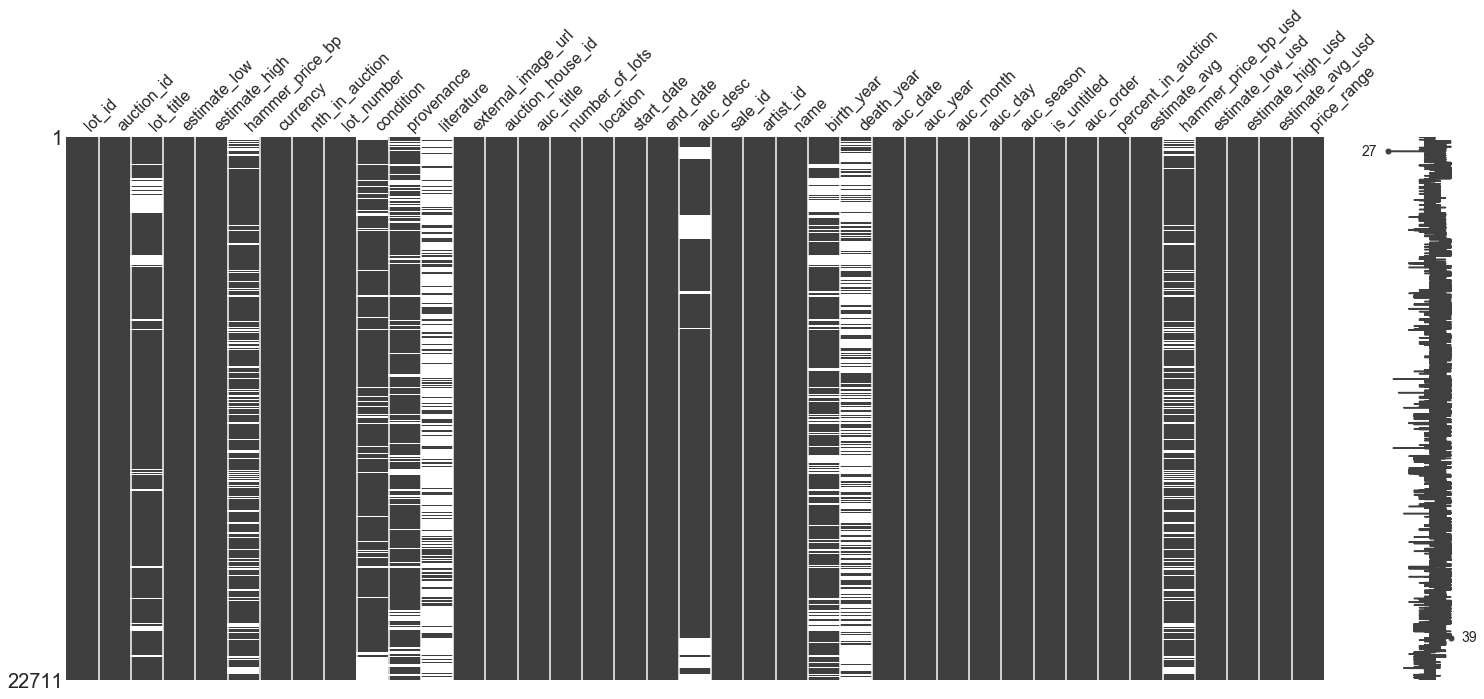

In [17]:
msno.matrix(df)

In [18]:
#check 
#change the 100% thing
#paracord- interactive
# temp=df.groupby("auc_id").size()

In [19]:
print(df[(df.auc_year > 2011) & (df.auc_year <= 2012)].shape)

(1462, 39)


(22711, 6)
(18810, 6)


,lot_id,hammer_price_bp_usd,location,auc_date,auc_year,external_image_url
174,22713,8750.0,NEW YORK,2010-03-09,2010,http://www.sothebys.com/content/dam/default/un...
175,22712,9375.0,NEW YORK,2010-03-09,2010,http://www.sothebys.com/content/dam/default/un...
176,22711,18750.0,NEW YORK,2010-03-09,2010,http://www.sothebys.com/content/dam/default/un...
177,22710,17500.0,NEW YORK,2010-03-09,2010,http://www.sothebys.com/content/dam/default/un...
178,22704,31250.0,NEW YORK,2010-03-09,2010,http://www.sothebys.com/content/dam/default/un...


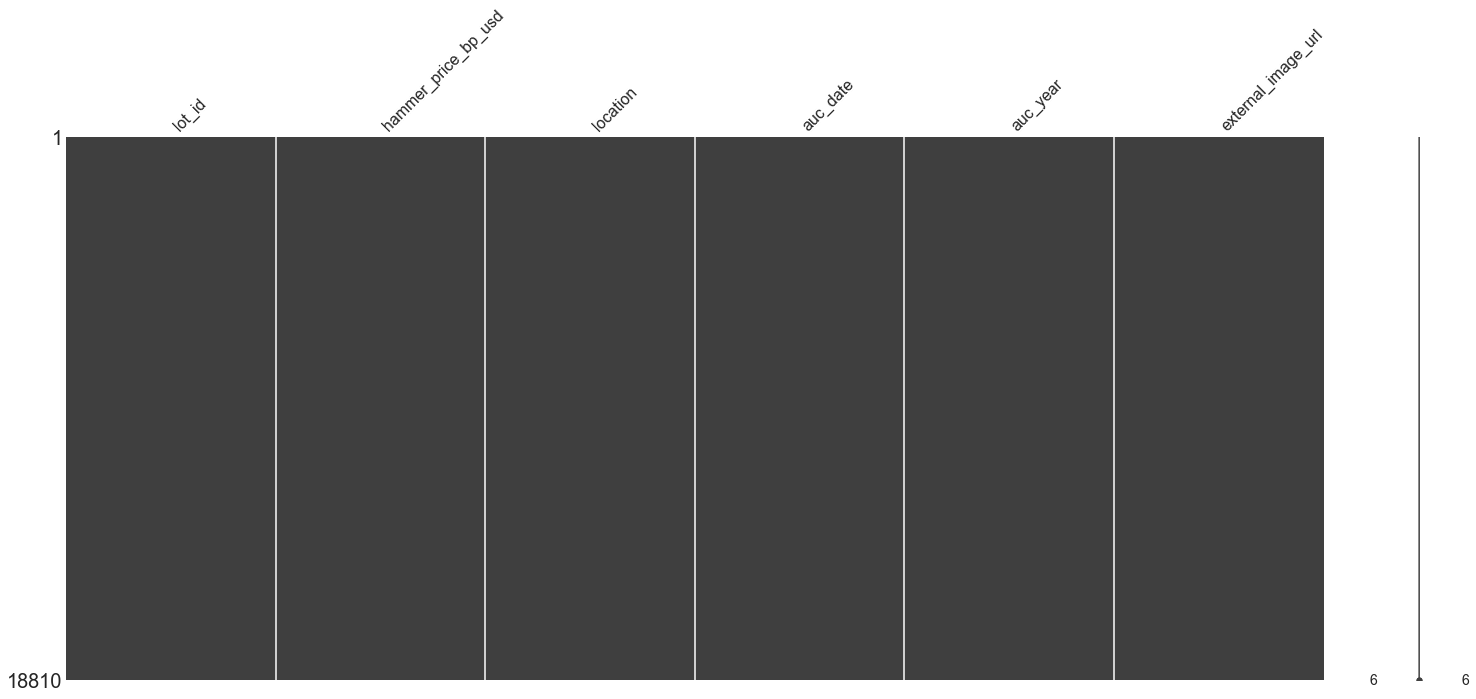

In [20]:
# from datetime import date

# start = min(df.auc_date).strftime('%Y-%m-%d')
# print(start)

# our first date is March 31 2006, so start timeline at January 1 2006
# date0 = date(2006, 1, 1)

# def calc_days(x):
#     y, m, d = [ int(x) for x in x.strftime('%Y-%m-%d').split("-") ]
#     new_date = date(y, m, d)
#     delta = new_date - date0
#     return delta.days

# df["timeline_days"] = df.auc_date.apply(calc_days)

interactive_df = df[['lot_id', 'hammer_price_bp_usd', 'location', 'auc_date', 'auc_year', 'external_image_url']].copy()
print(interactive_df.shape)
interactive_df.dropna(axis=0, inplace=True)
print(interactive_df.shape)

display(interactive_df.head())
msno.matrix(interactive_df)

In [21]:
interactive_df.to_json('interactive.json', orient='records')

In [22]:
print(interactive_df[interactive_df.auc_year == 2016])

       lot_id  hammer_price_bp_usd  location   auc_date  auc_year  \
11332    9474             37828.14    LONDON 2016-02-11      2016   
11334    9472             23417.42    LONDON 2016-02-11      2016   
11336    9470             43232.16    LONDON 2016-02-11      2016   
11337    9469             54040.20    LONDON 2016-02-11      2016   
11338    9468             18013.40    LONDON 2016-02-11      2016   
11339    9467             14410.72    LONDON 2016-02-11      2016   
11343    9463             57642.88    LONDON 2016-02-11      2016   
11345    9461              9006.70    LONDON 2016-02-11      2016   
11347    9459             63046.89    LONDON 2016-02-11      2016   
11348    9456             88265.65    LONDON 2016-02-11      2016   
11349    9455             99073.69    LONDON 2016-02-11      2016   
11350    9454             32424.12    LONDON 2016-02-11      2016   
11351    9452             36026.80    LONDON 2016-02-11      2016   
11354    9445             63046.89

In [23]:
display(interactive_df[interactive_df.lot_id == 4810])

,lot_id,hammer_price_bp_usd,location,auc_date,auc_year,external_image_url
15415,4810,2703960.0,PARIS,2016-12-07,2016,http://www.sothebys.com/content/dam/default/un...
